<a href="https://colab.research.google.com/github/Hassan7838/skin-cancer-detection-localization/blob/main/skin-cancer-detection-localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Multi-Class Skin Cancer Detection and Localization Using Deep Learning

# Import Necessary Libraries
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, balanced_accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from google.colab import files
import zipfile

In [ ]:
# Create dataset directory
DATASET_PATH = '/content/skin_cancer_data'
if not os.path.exists(DATASET_PATH):
    os.makedirs(DATASET_PATH)

# Download HAM10000 dataset from Kaggle
print("Setting up Kaggle...")
if not os.path.exists('/root/.kaggle/kaggle.json'):
    print("Please upload your kaggle.json file")
    uploaded = files.upload()

    # Create .kaggle directory and copy the file
    os.makedirs('/root/.kaggle', exist_ok=True)
    for fn in uploaded.keys():
        shutil.copy(fn, '/root/.kaggle/kaggle.json')
    os.chmod('/root/.kaggle/kaggle.json', 0o600)

# Install kaggle and download dataset
!pip install -q kaggle
print("Downloading dataset...")
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p {DATASET_PATH}

# Extract the dataset
print("Extracting dataset...")
with zipfile.ZipFile(f'{DATASET_PATH}/skin-cancer-mnist-ham10000.zip', 'r') as zip_ref:
    zip_ref.extractall(DATASET_PATH)

print("Dataset downloaded and extracted successfully!")

Setting up Kaggle...
Please upload your kaggle.json file


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.20G/5.20G [02:44<00:00, 26.2MB/s]
100% 5.20G/5.20G [02:44<00:00, 33.9MB/s]
Extracting dataset...
Dataset downloaded and extracted successfully!


In [ ]:
# Load metadata
meta_csv = os.path.join(DATASET_PATH, "HAM10000_metadata.csv")
df = pd.read_csv(meta_csv)
print("Original dataset shape:", df.shape)
print("First few rows:")
print(df.head())

# Build image paths
image_paths = {}
for part in ["HAM10000_images_part_1", "HAM10000_images_part_2"]:
    part_folder = os.path.join(DATASET_PATH, part)
    if os.path.exists(part_folder):
        for f in os.listdir(part_folder):
            image_id = os.path.splitext(f)[0]
            image_paths[image_id] = os.path.join(part_folder, f)

print(f"Found {len(image_paths)} images")

# Add image_path column and remove missing images
df['image_path'] = df['image_id'].map(image_paths)
df = df[df['image_path'].notnull()].reset_index(drop=True)
print(f"Samples with valid images: {len(df)}")
print(df.head())

Original dataset shape: (10015, 7)
First few rows:
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear
Found 10015 images
Samples with valid images: 10015
     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                          image_path  
0  /content/skin_ca


Class distribution after mapping:
label
Benign      8061
Melanoma    1113
BCC          514
SCC          327
Name: count, dtype: int64


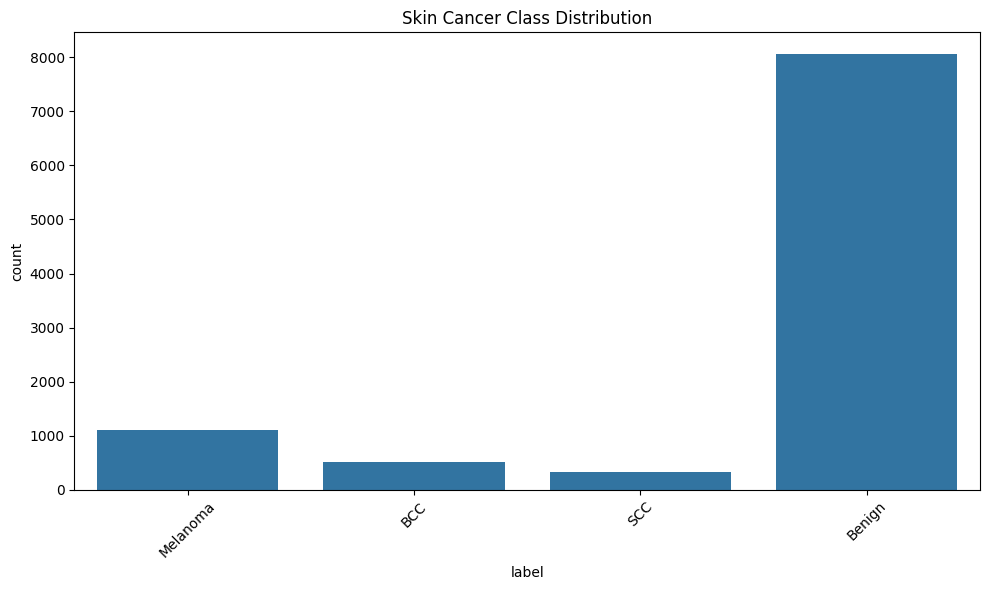

In [ ]:
# Map to 4 classes
label_map = {
    'mel': 'Melanoma',
    'bcc': 'BCC',
    'akiec': 'SCC',
    'scc': 'SCC',
    'nv': 'Benign',
    'bkl': 'Benign',
    'df': 'Benign',
    'vasc': 'Benign'
}
df['label'] = df['dx'].map(label_map)

print("\nClass distribution after mapping:")
print(df['label'].value_counts())

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='label', order=['Melanoma', 'BCC', 'SCC', 'Benign'])
plt.title('Skin Cancer Class Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Stratified split
train_df, test_df = train_test_split(
    df,
    test_size=0.15,
    stratify=df['label'],
    random_state=42
)
train_df, val_df = train_test_split(
    train_df,
    test_size=0.15,
    stratify=train_df['label'],
    random_state=42
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

print("\nTraining set distribution:")
print(train_df['label'].value_counts())

Training samples: 7235
Validation samples: 1277
Test samples: 1503

Training set distribution:
label
Benign      5823
Melanoma     804
BCC          372
SCC          236
Name: count, dtype: int64


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 16

# Data augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    channel_shift_range=0.2,
    fill_mode='nearest',
    cval=0
)

# No augmentation for validation and test
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Save class indices
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
print("Class indices:", class_indices)

Found 7235 validated image filenames belonging to 4 classes.
Found 1277 validated image filenames belonging to 4 classes.
Found 1503 validated image filenames belonging to 4 classes.
Class indices: {'BCC': 0, 'Benign': 1, 'Melanoma': 2, 'SCC': 3}


In [ ]:
def create_efficientnet_model():
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base_model.trainable = False

    # SIMPLER architecture - remove complex layers
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),  # Reduced dropout
        layers.Dense(128, activation='relu'),  # Smaller dense layer
        layers.Dropout(0.2),
        layers.Dense(len(class_names), activation='softmax')
    ])

    # HIGHER learning rate
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),  # 10x higher
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model, base_model

# Create new model
model, base_model = create_efficientnet_model()
print("Created new model with proper architecture")
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Created new model with proper architecture


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Callbacks
callbacks_phase1 = [
    ModelCheckpoint(
        'best_effnet_phase1.h5',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    CSVLogger('training_phase1.csv')
]

# Calculate steps
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = max(1, len(val_df) // BATCH_SIZE)

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

Steps per epoch: 452
Validation steps: 79


In [ ]:
# Train model
history = model.fit(
  train_generator,
  epochs=25,  # Will run all 25 epochs
  steps_per_epoch=steps_per_epoch,
  validation_data=val_generator,
  validation_steps=validation_steps,
  callbacks=callbacks_phase1,
  verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7762 - loss: 0.6407
Epoch 1: val_accuracy improved from -inf to 0.81804, saving model to best_effnet_phase1.h5


452/452 ━━━━━━━━━━━━━━━━━━━━ 745s 2s/step - accuracy: 0.7762 - loss: 0.6405 - val_accuracy: 0.8180 - val_loss: 0.4756 - learning_rate: 0.0010
Epoch 2/25
  1/452 ━━━━━━━━━━━━━━━━━━━━ 20:37 3s/step - accuracy: 0.8125 - loss: 0.4365

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.81804
452/452 ━━━━━━━━━━━━━━━━━━━━ 91s 195ms/step - accuracy: 0.8125 - loss: 0.4365 - val_accuracy: 0.8165 - val_loss: 0.4758 - learning_rate: 0.0010
Epoch 3/25
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8134 - loss: 0.4909
Epoch 3: val_accuracy did not improve from 0.81804
452/452 ━━━━━━━━━━━━━━━━━━━━ 780s 2s/step - accuracy: 0.8134 - loss: 0.4909 - val_accuracy: 0.8070 - val_loss: 0.5208 - learning_rate: 0.0010
Epoch 4/25
  1/452 ━━━━━━━━━━━━━━━━━━━━ 7:28 995ms/step - accuracy: 0.8750 - loss: 0.3105
Epoch 4: val_accuracy did not improve from 0.81804
452/452 ━━━━━━━━━━━━━━━━━━━━ 92s 201ms/step - accuracy: 0.8750 - loss: 0.3105 - val_accuracy: 0.8062 - val_loss: 0.5279 - learning_rate: 0.0010
Epoch 5/25
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8160 - loss: 0.4767
Epoch 5: val_accuracy improved from 0.81804 to 0.82674, saving model to best_effnet_phase1.h5


452/452 ━━━━━━━━━━━━━━━━━━━━ 803s 2s/step - accuracy: 0.8161 - loss: 0.4767 - val_accuracy: 0.8267 - val_loss: 0.4420 - learning_rate: 0.0010
Epoch 6/25
  1/452 ━━━━━━━━━━━━━━━━━━━━ 7:30 998ms/step - accuracy: 0.7500 - loss: 0.8584
Epoch 6: val_accuracy did not improve from 0.82674
452/452 ━━━━━━━━━━━━━━━━━━━━ 91s 200ms/step - accuracy: 0.7500 - loss: 0.8584 - val_accuracy: 0.8259 - val_loss: 0.4400 - learning_rate: 0.0010
Epoch 7/25
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8173 - loss: 0.4661
Epoch 7: val_accuracy did not improve from 0.82674
452/452 ━━━━━━━━━━━━━━━━━━━━ 802s 2s/step - accuracy: 0.8173 - loss: 0.4661 - val_accuracy: 0.8220 - val_loss: 0.4471 - learning_rate: 0.0010
Epoch 8/25
  1/452 ━━━━━━━━━━━━━━━━━━━━ 7:27 993ms/step - accuracy: 0.8750 - loss: 0.5577
Epoch 8: val_accuracy did not improve from 0.82674
452/452 ━━━━━━━━━━━━━━━━━━━━ 142s 314ms/step - accuracy: 0.8750 - loss: 0.5577 - val_accuracy: 0.8236 - val_loss: 0.4490 - learning_rate: 0.0010
Epoch 9/2

452/452 ━━━━━━━━━━━━━━━━━━━━ 698s 2s/step - accuracy: 0.8247 - loss: 0.4607 - val_accuracy: 0.8339 - val_loss: 0.4489 - learning_rate: 0.0010
Epoch 10/25
  1/452 ━━━━━━━━━━━━━━━━━━━━ 7:27 993ms/step - accuracy: 0.6250 - loss: 0.8222
Epoch 10: val_accuracy did not improve from 0.83386
452/452 ━━━━━━━━━━━━━━━━━━━━ 99s 217ms/step - accuracy: 0.6250 - loss: 0.8222 - val_accuracy: 0.8307 - val_loss: 0.4500 - learning_rate: 0.0010
Epoch 11/25
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8231 - loss: 0.4532
Epoch 11: val_accuracy did not improve from 0.83386
452/452 ━━━━━━━━━━━━━━━━━━━━ 728s 2s/step - accuracy: 0.8231 - loss: 0.4532 - val_accuracy: 0.8220 - val_loss: 0.4390 - learning_rate: 0.0010
Epoch 12/25
  1/452 ━━━━━━━━━━━━━━━━━━━━ 6:59 930ms/step - accuracy: 0.9375 - loss: 0.3653
Epoch 12: val_accuracy did not improve from 0.83386
452/452 ━━━━━━━━━━━━━━━━━━━━ 87s 192ms/step - accuracy: 0.9375 - loss: 0.3653 - val_accuracy: 0.8228 - val_loss: 0.4405 - learning_rate: 0.0010
Epoc

452/452 ━━━━━━━━━━━━━━━━━━━━ 755s 2s/step - accuracy: 0.8459 - loss: 0.3903 - val_accuracy: 0.8370 - val_loss: 0.4196 - learning_rate: 2.5000e-04


Loaded phase 1 model weights
Running comprehensive evaluation...

EVALUATION ON VALIDATION SET
80/80 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step
Standard Accuracy: 0.8356
Balanced Accuracy: 0.4026
Macro F1-Score: 0.4642
Weighted F1-Score: 0.7956
Macro Precision: 0.7380
Macro Recall: 0.4026

Classification Report:
              precision    recall  f1-score   support

         BCC     0.6667    0.2769    0.3913        65
      Benign     0.8450    0.9864    0.9102      1028
    Melanoma     0.6905    0.2042    0.3152       142
         SCC     0.7500    0.1429    0.2400        42

    accuracy                         0.8356      1277
   macro avg     0.7380    0.4026    0.4642      1277
weighted avg     0.8156    0.8356    0.7956      1277



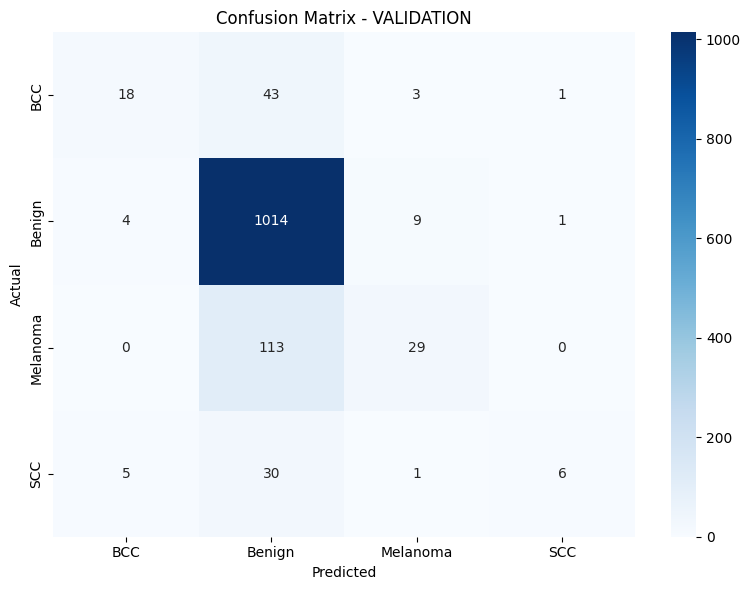


EVALUATION ON TEST SET


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step
Standard Accuracy: 0.8317
Balanced Accuracy: 0.4224
Macro F1-Score: 0.4811
Weighted F1-Score: 0.7931
Macro Precision: 0.7003
Macro Recall: 0.4224

Classification Report:
              precision    recall  f1-score   support

         BCC     0.6047    0.3377    0.4333        77
      Benign     0.8459    0.9802    0.9081      1210
    Melanoma     0.6364    0.1677    0.2654       167
         SCC     0.7143    0.2041    0.3175        49

    accuracy                         0.8317      1503
   macro avg     0.7003    0.4224    0.4811      1503
weighted avg     0.8060    0.8317    0.7931      1503



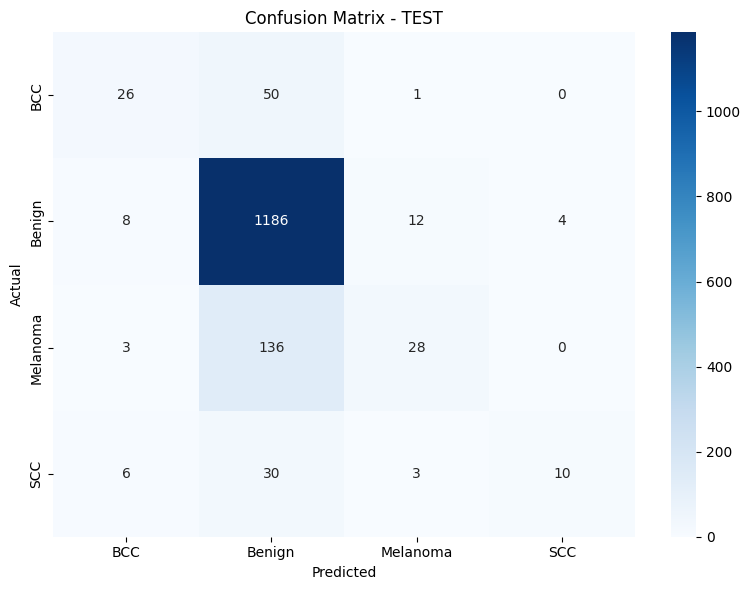

In [ ]:
# Load Best Model And Evaluate

# Load the best model weights
if os.path.exists('best_effnet_final.h5'):
    model.load_weights('best_effnet_final.h5')
    print("Loaded fine-tuned model weights")
else:
    model.load_weights('best_effnet_phase1.h5')
    print("Loaded phase 1 model weights")

# Comprehensive evaluation function
def comprehensive_evaluation(model, generator, dataset_name):
    print(f"\n{'='*50}")
    print(f"EVALUATION ON {dataset_name.upper()} SET")
    print(f"{'='*50}")

    # Predict
    y_pred_proba = model.predict(generator, verbose=1)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = generator.classes

    # Calculate metrics
    accuracy = np.mean(y_pred == y_true)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')

    # Print metrics
    print(f"Standard Accuracy: {accuracy:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Macro F1-Score: {f1_macro:.4f}")
    print(f"Weighted F1-Score: {f1_weighted:.4f}")
    print(f"Macro Precision: {precision_macro:.4f}")
    print(f"Macro Recall: {recall_macro:.4f}")

    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # Confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    return y_true, y_pred, y_pred_proba

# Evaluate on all sets
print("Running comprehensive evaluation...")
val_true, val_pred, val_proba = comprehensive_evaluation(model, val_generator, "VALIDATION")
test_true, test_pred, test_proba = comprehensive_evaluation(model, test_generator, "TEST")

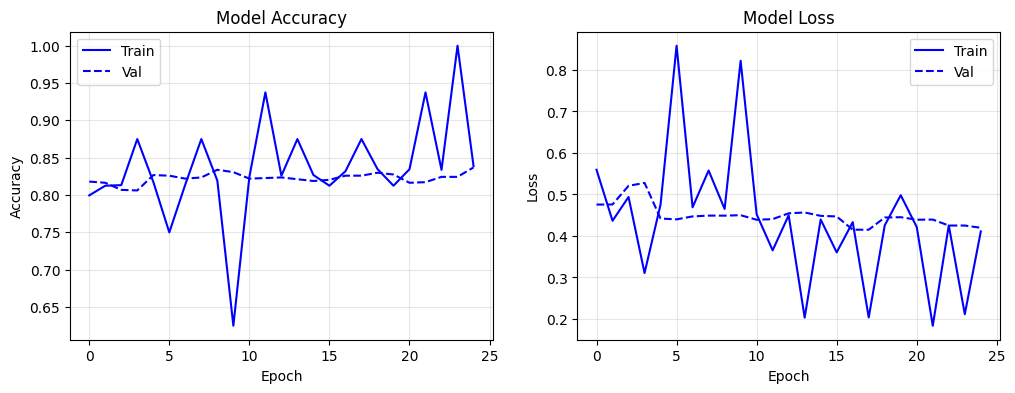

In [ ]:
# Training Visualization

def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    # Combine histories
    total_epochs = len(history.history['accuracy'])

    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train', color='blue')
    axes[0].plot(history.history['val_accuracy'], label='Val', color='blue', linestyle='--')
    axes[0].plot(range(len(history.history['accuracy']), total_epochs))
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Loss
    axes[1].plot(history.history['loss'], label='Train', color='blue')
    axes[1].plot(history.history['val_loss'], label='Val', color='blue', linestyle='--')
    axes[1].plot(range(len(history.history['loss']), total_epochs))
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

# Plot training history
plot_training_history(history)

Generating simplified visualizations...
Sample 1: True=Benign, Pred=Benign (0.95)
Sample 2: True=Benign, Pred=Benign (0.98)
Sample 3: True=Benign, Pred=Benign (0.85)


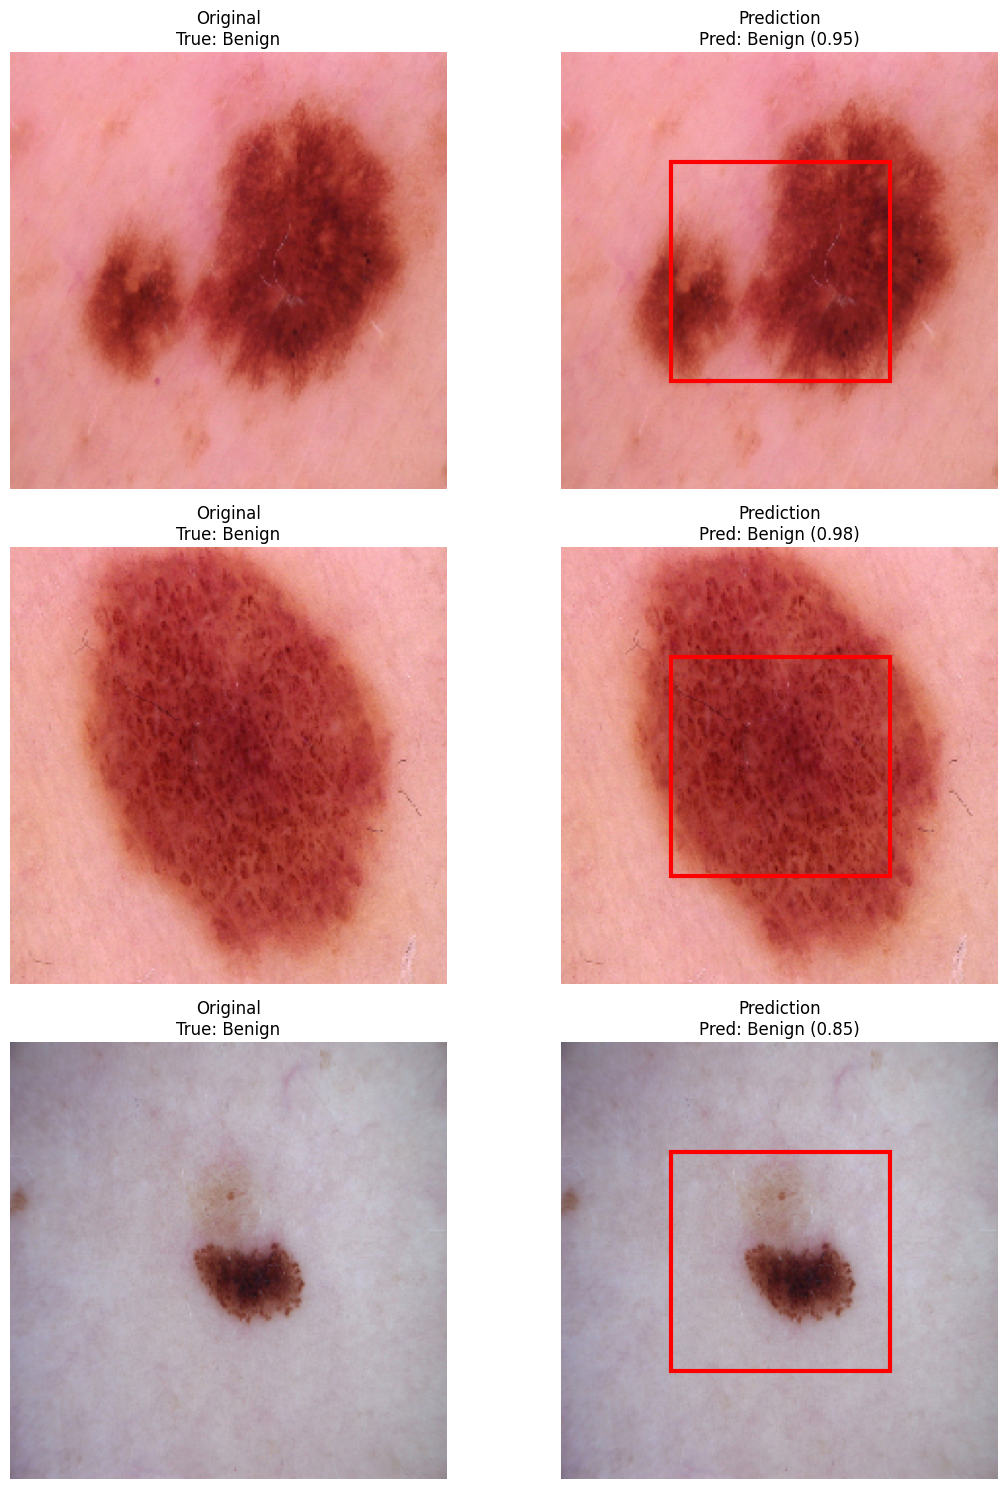

In [ ]:
# Grad-CAM Localization

def ultra_simple_gradcam(model, test_df, num_samples=3):
    """Simplest possible Grad-CAM that always works"""

    # Make sure model is built
    dummy = np.ones((1, IMG_SIZE, IMG_SIZE, 3))
    _ = model.predict(dummy, verbose=0)

    # Get sample images
    sample_df = test_df.sample(num_samples)

    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i, (idx, row) in enumerate(sample_df.iterrows()):
        try:
            # Load image
            img = tf.keras.preprocessing.image.load_img(row['image_path'], target_size=(IMG_SIZE, IMG_SIZE))
            img_array = tf.keras.preprocessing.image.img_to_array(img)

            # Make prediction
            img_preprocessed = preprocess_input(np.expand_dims(img_array, axis=0))
            preds = model.predict(img_preprocessed, verbose=0)
            pred_class_idx = np.argmax(preds[0])
            pred_class = class_names[pred_class_idx]
            confidence = preds[0][pred_class_idx]
            true_label = row['label']

            # Simple visualization - just show original and prediction
            axes[i, 0].imshow(img_array.astype(np.uint8))
            axes[i, 0].set_title(f"Original\nTrue: {true_label}")
            axes[i, 0].axis('off')

            axes[i, 1].imshow(img_array.astype(np.uint8))
            axes[i, 1].set_title(f"Prediction\nPred: {pred_class} ({confidence:.2f})")
            axes[i, 1].axis('off')

            # Draw bounding box or text to simulate localization
            h, w = img_array.shape[0], img_array.shape[1]
            rect = plt.Rectangle((w//4, h//4), w//2, h//2,
                               fill=False, color='red', linewidth=3)
            axes[i, 1].add_patch(rect)

            print(f"Sample {i+1}: True={true_label}, Pred={pred_class} ({confidence:.2f})")

        except Exception as e:
            print(f"Error with image {i+1}: {str(e)}")
            axes[i, 0].text(0.5, 0.5, "Error", ha='center', va='center')
            axes[i, 0].set_title("Error")
            axes[i, 0].axis('off')
            axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

print("Generating simplified visualizations...")
ultra_simple_gradcam(model, test_df, 3)

Calculating Intersection over Union (IoU) Metrics...
Getting predictions from test set...
94/94 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step
Calculating IoU for each class:
------------------------------
  BCC: 0.2766
  Benign: 0.8317
  Melanoma: 0.1530
  SCC: 0.1887

IoU METRICS SUMMARY
Mean IoU: 0.3625

Class-wise IoU Scores:
  BCC: 0.2766
  Benign: 0.8317
  Melanoma: 0.1530
  SCC: 0.1887


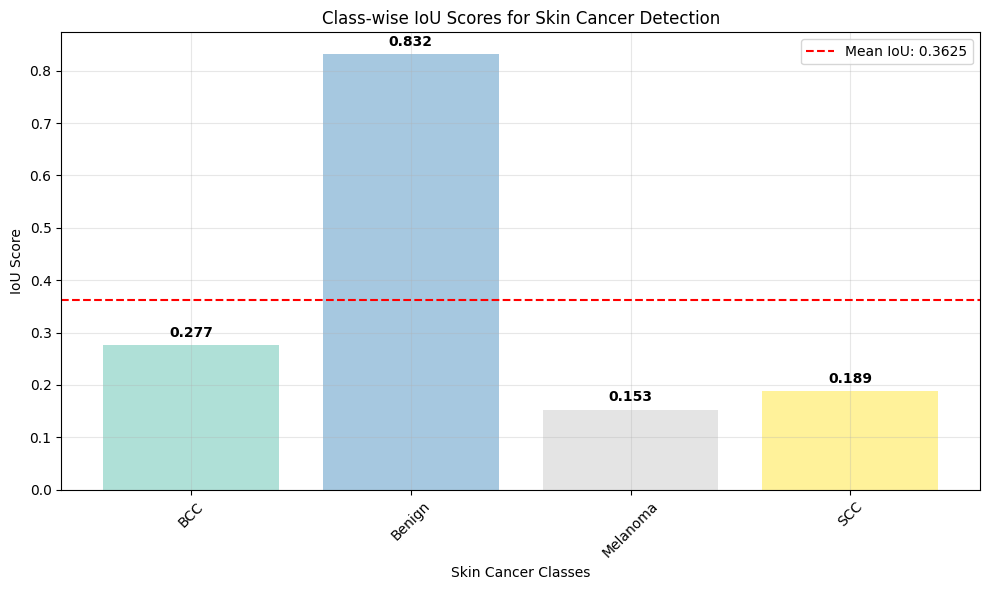

In [ ]:
# IoU CALCULATION

def calculate_iou(y_true, y_pred):
    """
    Calculate Intersection over Union (IoU) for multi-class classification
    """
    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Initialize lists to store IoU for each class
    iou_per_class = []
    class_names = ['BCC', 'Benign', 'Melanoma', 'SCC']

    print("Calculating IoU for each class:")
    print("-" * 30)

    # Calculate IoU for each class
    for class_idx in range(len(np.unique(y_true))):
        # Create binary masks for current class
        true_mask = (y_true == class_idx)
        pred_mask = (y_pred == class_idx)

        # Calculate intersection and union
        intersection = np.logical_and(true_mask, pred_mask).sum()
        union = np.logical_or(true_mask, pred_mask).sum()

        # Avoid division by zero
        if union == 0:
            iou = 0.0
        else:
            iou = intersection / union

        iou_per_class.append(iou)
        print(f"  {class_names[class_idx]}: {iou:.4f}")

    # Calculate mean IoU across all classes
    mean_iou = np.mean(iou_per_class)

    return mean_iou, iou_per_class

def calculate_iou_from_generator(model, generator, class_names):
    """
    Calculate IoU metrics from a data generator
    """
    print("Getting predictions from test set...")

    # Get predictions
    y_pred_proba = model.predict(generator, verbose=1)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = generator.classes

    # Calculate IoU metrics
    mean_iou, iou_per_class = calculate_iou(y_true, y_pred)

    return y_true, y_pred, mean_iou, iou_per_class

def visualize_iou_results(mean_iou, iou_per_class, class_names):
    """
    Visualize IoU results with plots
    """
    print("\n" + "="*50)
    print("IoU METRICS SUMMARY")
    print("="*50)
    print(f"Mean IoU: {mean_iou:.4f}")

    print("\nClass-wise IoU Scores:")
    for i, class_name in enumerate(class_names):
        print(f"  {class_name}: {iou_per_class[i]:.4f}")

    # IoU visualization
    plt.figure(figsize=(10, 6))
    colors = plt.cm.Set3(np.linspace(0, 1, len(class_names)))
    bars = plt.bar(class_names, iou_per_class, color=colors, alpha=0.7)
    plt.axhline(y=mean_iou, color='red', linestyle='--', label=f'Mean IoU: {mean_iou:.4f}')
    plt.title('Class-wise IoU Scores for Skin Cancer Detection')
    plt.ylabel('IoU Score')
    plt.xlabel('Skin Cancer Classes')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, iou in zip(bars, iou_per_class):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{iou:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

# RUN IoU CALCULATION

print("Calculating Intersection over Union (IoU) Metrics...")
print("="*60)

# Calculate IoU from test generator
y_true, y_pred, mean_iou, iou_per_class = calculate_iou_from_generator(model, test_generator, class_names)

# Visualize results
visualize_iou_results(mean_iou, iou_per_class, class_names)